# Modeling cleavage site heterogeneity

**Purpose**: To assess the performance of the PolyaCleavage model on 3'READS holdout testing data and non-3'READS data.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## HELPER FUNCTIONS

In [4]:
def load_predictions(data_path, verbose = False):
    
    data = pd.read_csv(data_path, sep = '\t')
    
    if ('normvec' in data.columns):
        data['obs_cleavage'] = data['normvec'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")]))
    elif ('readvec' in data.columns):
        data['obs_cleavage'] = data['readvec'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")]))
    elif ('scorevec' in data.columns):
        data['obs_cleavage'] = data['scorevec'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")]))

    data['obs_entropy'] = data['obs_cleavage'].apply(lambda x : cleavage.calculate_entropy_from_vector(x))
    data['obs_mcp']     = data['obs_cleavage'].apply(lambda x : cleavage.calculate_mcp_from_vector(x))
    data['obs_entropy_bins'] = pd.qcut(data['obs_entropy'], q = 5, labels = np.arange(1,6,1))

    ##
    
    if ('pred_cleavage' in data.columns):
        data['pred_cleavage'] = data['pred_cleavage'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")]))
    elif ('cleavage_vector' in data.columns):
        data['pred_cleavage'] = data['cleavage_vector'].apply(lambda x : np.asarray([float(_) for _ in x.strip("][").split(", ")]))
        
    data['pred_entropy'] = data['pred_cleavage'].apply(lambda x : cleavage.calculate_entropy_from_vector(x))
    data['pred_mcp']     = data['pred_cleavage'].apply(lambda x : cleavage.calculate_mcp_from_vector(x))
    
    data['pred_normclv'] = data['pred_cleavage'].apply(lambda x : cleavage.background_normalize_cleavage_probabilities(x))
    data['pred_normmcp'] = data['pred_normclv'].apply(lambda x : cleavage.calculate_mcp_from_vector(x))
    data['pred_norment'] = data['pred_normclv'].apply(lambda x : cleavage.calculate_entropy_from_vector(x))
    
    if (verbose):
        print(f"{os.path.basename(data_path)}: shape={data.shape}")
    
    return data


In [5]:
def visualize_mcp_correlation(plot_data, plot_desc, data_desc):
    
    fig,ax = plt.subplots(1, 1, figsize = (1.75, 2))

    scorr, pcorr = cleavage.plot_cleavage_evaluation(fig, ax, plot_data['obs_mcp'], plot_data['pred_mcp'], corr = False)

    ax.set_xlabel("Observed mean cleavage position")
    ax.set_ylabel("Predicted mean cleavage position")

    ax.set_xlim(0,50)
    ax.set_xticks(np.arange(0,51,25))
    ax.set_xticklabels(np.arange(-25,26,25))

    ax.set_ylim(0,50)
    ax.set_yticks(np.arange(0,51,25))
    ax.set_yticklabels(np.arange(-25,26,25))

    plt.tight_layout(rect = [0, 0.03, 1, 0.97])
    plt.savefig(os.path.join(OUTDIR, f'cleavage_probabilities.{data_desc}.correlation_mcp.{plot_desc}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()

    print(f"Corresponding metrics:\n\tPearson correlation = {pcorr:.03f}\n\tSpearman correlation = {scorr:.03f}")
    
    return


In [6]:
def visualize_ent_correlation(plot_data, plot_desc, data_desc):
    
    fig,ax = plt.subplots(1, 1, figsize = (1.75, 1.5))
    
    scorr, pcorr = cleavage.plot_cleavage_evaluation(fig, ax, plot_data['obs_entropy'], plot_data['pred_entropy'], aspect = False, corr = False)

    ax.set_xlabel("Observed entropy")
    ax.set_ylabel("Predicted entropy")

    ax.set_xlim(0,4)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    
    ax.set_ylim(1,4)
    ax.yaxis.set_major_locator(MultipleLocator(1))

    plt.tight_layout(rect = [0, 0.03, 1, 0.97])
    plt.savefig(os.path.join(OUTDIR, f'cleavage_probabilities.{data_desc}.correlation_ent.{plot_desc}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()

    print(f"Corresponding metrics:\n\tPearson correlation = {pcorr:.03f}\n\tSpearman correlation = {scorr:.03f}")
    
    return


In [7]:
def visualize_ent_boxplots(plot_data, plot_desc, data_desc):
    
    fig,ax = plt.subplots(1,1, figsize = (1,1.5))
    
    plot_data['obs_entropy_bins2'] = pd.qcut(plot_data['obs_entropy'], q = 5, labels = np.arange(1,6,1))

    x = 'obs_entropy_bins2'
    y = 'pred_entropy'

    sns.boxplot(data = plot_data, x = x, y = y, color = 'lightgray',
                boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
                medianprops = {'color' : 'black', 'linewidth' : 0.5},
                whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
                capprops = {'color' : 'black', 'linewidth' : 0.5},
                flierprops = {'color' : 'black'},
                showfliers = False, 
                ax = ax)

    ax.set_xlabel("Observed cleavage entropy group")

    ax.set_ylim(None,4)
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_ylabel("Predicted entropy")

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig(os.path.join(OUTDIR, f'cleavage_probabilities.{data_desc}.boxplots_ent.{plot_desc}.svg'), format = 'svg', dpi = 600, transparent = True)
    plt.show()


    print("\nSummary data:")
    print(plot_data.groupby(x)[y].agg(['count','median','mean','min','max']))

    print("\nWilcoxon rank sum tests:")
    print("5 vs 1:", st.ranksums(plot_data.loc[plot_data[x] == 1, y],
                                 plot_data.loc[plot_data[x] == 5, y]))


    return


## IMPORTS AND SETUP

In [8]:
from paper_utilities import cleavage

In [9]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'cleavage_model_development')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


## Model performance on 3'READS test set

In [10]:
reads3_preds_site10 = load_predictions(os.path.join(RESOURCES, 'polyacleavage_predictions.scer_reads3_test_data.20240423-152708.txt'), verbose = True)


polyacleavage_predictions.scer_reads3_test_data.20240423-152708.txt: shape=(4046, 25)


#### Correlation in mean cleavage position

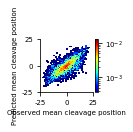

Corresponding metrics:
	Pearson correlation = 0.763
	Spearman correlation = 0.751


In [11]:
visualize_mcp_correlation(reads3_preds_site10, 'test_all', 'reads3_site10')


#### Correlation in cleavage vector entropy

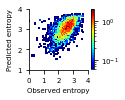

Corresponding metrics:
	Pearson correlation = 0.593
	Spearman correlation = 0.593


In [12]:
visualize_ent_correlation(reads3_preds_site10, 'test_all', 'reads3_site10')


#### Trends in cleavage vector entropy

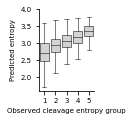


Summary data:
                   count    median      mean       min       max
obs_entropy_bins2                                               
1                    810  2.722520  2.727703  0.857998  3.582568
2                    809  2.937104  2.937424  2.027384  3.675167
3                    809  3.082459  3.068998  2.156531  3.705483
4                    809  3.186480  3.177782  1.996477  3.738114
5                    809  3.358069  3.336629  2.202805  3.782208

Wilcoxon rank sum tests:
5 vs 1: RanksumsResult(statistic=-29.009397697013206, pvalue=5.0081614049749224e-185)


In [13]:
visualize_ent_boxplots(reads3_preds_site10, 'test_all', 'reads3_site10')


### Golden sites

In [14]:
gold_preds_site10 = load_predictions(os.path.join(RESOURCES, 'polyacleavage_predictions.scer_golden_dist5.20240423-152708.txt'), verbose = True)


polyacleavage_predictions.scer_golden_dist5.20240423-152708.txt: shape=(11673, 25)


#### Correlation in mean cleavage position

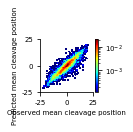

Corresponding metrics:
	Pearson correlation = 0.914
	Spearman correlation = 0.908


In [15]:
visualize_mcp_correlation(gold_preds_site10, 'gold_all', 'reads3_site10')


#### Correlation in cleavage vector entropy

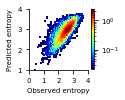

Corresponding metrics:
	Pearson correlation = 0.787
	Spearman correlation = 0.777


In [16]:
visualize_ent_correlation(gold_preds_site10, 'gold_all', 'reads3_site10')


#### Trends in cleavage vector entropy

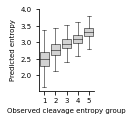


Summary data:
                   count    median      mean       min       max
obs_entropy_bins2                                               
1                   2335  2.494404  2.490931  0.783713  3.591145
2                   2334  2.775394  2.786220  1.974781  3.656388
3                   2335  2.954326  2.955372  2.257270  3.691799
4                   2334  3.092907  3.097384  2.357397  3.675857
5                   2335  3.318953  3.309096  2.554935  3.783803

Wilcoxon rank sum tests:
5 vs 1: RanksumsResult(statistic=-57.015746020871504, pvalue=0.0)


In [17]:
visualize_ent_boxplots(gold_preds_site10, 'gold_all', 'reads3_site10')


## Model performance on non-3'READS data

### 3P-seq

In [18]:
p3seq_preds_site10 = load_predictions(os.path.join(RESOURCES, 'polyacleavage_predictions.scer_clv_3Pseq.20240423-152708.txt'), verbose = True)


polyacleavage_predictions.scer_clv_3Pseq.20240423-152708.txt: shape=(15808, 25)


#### Correlation in mean cleavage position

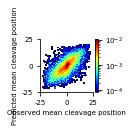

Corresponding metrics:
	Pearson correlation = 0.686
	Spearman correlation = 0.688


In [19]:
visualize_mcp_correlation(p3seq_preds_site10, 'p3seq_all', 'reads3_site10')


#### Correlation in cleavage vector entropy

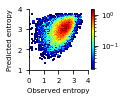

Corresponding metrics:
	Pearson correlation = 0.437
	Spearman correlation = 0.450


In [20]:
visualize_ent_correlation(p3seq_preds_site10, 'p3seq_all', 'reads3_site10')


#### Trends in cleavage vector entropy

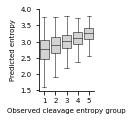


Summary data:
                   count    median      mean       min       max
obs_entropy_bins2                                               
1                   3162  2.771798  2.755438  1.290360  3.766944
2                   3161  2.900409  2.887192  1.618382  3.760692
3                   3162  3.010487  2.992849  1.838145  3.780586
4                   3161  3.101094  3.085912  2.014658  3.740511
5                   3162  3.261720  3.236550  2.142001  3.788968

Wilcoxon rank sum tests:
5 vs 1: RanksumsResult(statistic=-46.16822296067223, pvalue=0.0)


In [21]:
visualize_ent_boxplots(p3seq_preds_site10, 'p3seq_all', 'reads3_site10')


### Helicos sequencing data

In [22]:
helicos_preds_site10 = load_predictions(os.path.join(RESOURCES, 'polyacleavage_predictions.scer_clv_Helicos.20240423-152708.txt'), verbose = True)


polyacleavage_predictions.scer_clv_Helicos.20240423-152708.txt: shape=(21006, 25)


#### Correlation in mean cleavage position

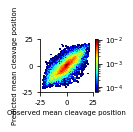

Corresponding metrics:
	Pearson correlation = 0.774
	Spearman correlation = 0.771


In [23]:
visualize_mcp_correlation(helicos_preds_site10, 'helicos_all', 'reads3_site10')


#### Correlation in cleavage vector entropy

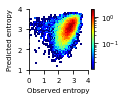

Corresponding metrics:
	Pearson correlation = 0.411
	Spearman correlation = 0.473


In [24]:
visualize_ent_correlation(helicos_preds_site10, 'helicos_all', 'reads3_site10')


#### Trends in cleavage vector entropy

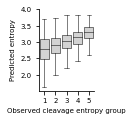


Summary data:
                   count    median      mean       min       max
obs_entropy_bins2                                               
1                   4202  2.796340  2.772918  0.657249  3.711073
2                   4201  2.913066  2.899675  1.761273  3.815164
3                   4201  3.021792  3.010647  1.628725  3.820360
4                   4201  3.138732  3.120976  1.732160  3.816863
5                   4201  3.298049  3.264524  2.101008  3.834672

Wilcoxon rank sum tests:
5 vs 1: RanksumsResult(statistic=-54.80994535432452, pvalue=0.0)


In [25]:
visualize_ent_boxplots(helicos_preds_site10, 'helicos_all', 'reads3_site10')
